# Las losowy

In [1]:
import numpy as np
import random
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, roc_curve, RocCurveDisplay, auc, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import time

In [2]:
def metrics(y_true, y_pred):
    print('accuracy:', accuracy_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print('sensitivity:', recall_score(y_true, y_pred))
    print('specificity:', cm[0][0]/(cm[0][0]+cm[0][1]))
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

In [3]:
def surface(classifier, xi, yi):
    x = np.linspace(-5, 5, 1000)
    y = np.linspace(-5, 5, 1000)

    X, Y = np.meshgrid(x,y)
    Z = []

    for i in range(len(X)):
        for j in range(len(Y)):
            Z.append(classifier.predict(np.array([X[i,j], Y[i,j]]).reshape(1, -1)))
                    
    Z = np.reshape(Z, X.shape)
        
    plt.scatter(xi[yi==0,0], xi[yi==0,1], label='Klasa 0')
    plt.scatter(xi[yi==1,0], xi[yi==1,1], label='Klasa 1')
    plt.legend()
    plt.contourf(X, Y, Z, alpha=0.3)
    plt.show()

In [4]:
def surface_sk(classifier, xi, yi):
    x = np.linspace(-5, 5, 100)
    y = np.linspace(-5, 5, 100)

    X, Y = np.meshgrid(x,y)
    Z = []

    for i in range(len(X)):
        for j in range(len(Y)):
            Z.append(classifier.predict(np.array([X[i,j], Y[i,j]]).reshape(1, -1)))
                    
    Z = np.reshape(Z, X.shape)
        
    plt.scatter(xi[yi==0,0], xi[yi==0,1], label='Klasa 0')
    plt.scatter(xi[yi==1,0], xi[yi==1,1], label='Klasa 1')
    plt.legend()
    plt.contourf(X, Y, Z, alpha=0.3)
    plt.show()

## Generowanie zbiorów

In [5]:
x1, y1 = make_classification(random_state=254448, n_samples=2548, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1)
x2, y2 = make_moons(n_samples=2548, random_state=254448, shuffle=True)
x3, y3 = make_classification(random_state=254448, n_samples=2548, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2)

x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, random_state=254448, stratify=y1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, random_state=254448, stratify=y2)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, random_state=254448, stratify=y3)

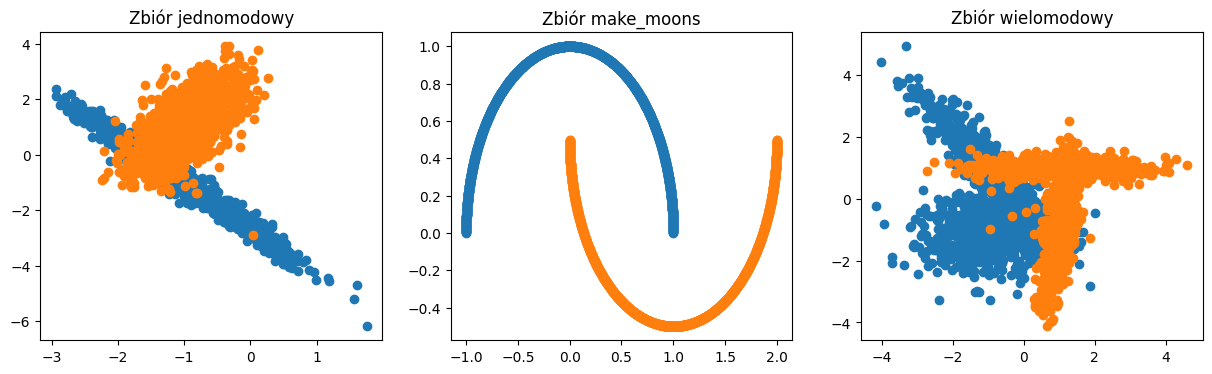

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(15)

ax1.scatter(x1[y1==0,0], x1[y1==0,1])
ax1.scatter(x1[y1==1,0], x1[y1==1,1])
ax1.set_title('Zbiór jednomodowy')

ax2.scatter(x2[y2==0,0], x2[y2==0,1])
ax2.scatter(x2[y2==1,0], x2[y2==1,1])
ax2.set_title('Zbiór make_moons')

ax3.scatter(x3[y3==0,0], x3[y3==0,1])
ax3.scatter(x3[y3==1,0], x3[y3==1,1])
ax3.set_title('Zbiór wielomodowy')
plt.show()

## Implementacja lasu losowego

In [6]:
class RandomTreeImplementation():

    def bagging(self, x):
        self.n_samples = len(x)
        indices = random.choices(range(self.n_samples), k=self.n_samples)
        self.bagging_indices = indices
        
        return indices
    
    def fit_tree(self, x, y, max_depth=None):
        self.max_depth = max_depth
        self.n_classes_ = 2
        ind = self.bagging(x)

        if type(x) is pd.core.frame.DataFrame:
            self.tree_ = self.grow_tree(x.loc[ind], y.loc[ind])
        else:
            self.tree_ = self.grow_tree(x[ind], y[ind])

    def grow_tree(self, x, y, depth=0):
        if self.gini(y) == 0:
            if type(y[0]) is np.ndarray:
                return {'class': y[0][0]}
            else:
                return {'class': y[0]}

        if self.max_depth is not None and depth >= self.max_depth:
            feature1 = 0
            feature0 = 0
            for i in y:
                if i==1:
                    feature1 += 1
                else:
                    feature0 += 1 
            return {'class': 1 if feature1 > feature0 else 0}

        best_feature, best_threshold = self.best_split(x, y)
        
        if best_feature is None:
            return {'class': np.argmax(np.bincount(y))}

        left_indices = x[:, best_feature] < best_threshold
        right_indices = x[:, best_feature] >= best_threshold

        left_tree = self.grow_tree(x[left_indices], y[left_indices], depth + 1)
        right_tree = self.grow_tree(x[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature,
                'threshold': best_threshold,
                'left': left_tree,
                'right': right_tree}

    def best_split(self, x, y):
        n_samples, n_features = x.shape
        best_info_gain = -1
        best_feature = None
        best_threshold = None
        
        gini_tree = self.gini(y)

        random_features = random.sample(range(n_features), int(np.sqrt(n_features)))
        
        for feature in random_features:
            thresholds = np.linspace(min(x[:, feature]), max(x[:, feature]))
            for threshold in thresholds:
                left_indices = x[:, feature] < threshold
                right_indices = x[:, feature] >= threshold

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                gini_left = self.gini(y[left_indices])
                gini_right = self.gini(y[right_indices])
                gini_split = (len(left_indices) / n_samples * gini_left +
                              len(right_indices) / n_samples * gini_right)

                info_gain = gini_tree - gini_split

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def gini(self, y):
        n_samples = len(y)
        
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / n_samples
        
        return 1-np.sum(probabilities**2)

    def predict(self, X):
        return [self.predict_tree(x, self.tree_) for x in X]

    def predict_tree(self, x, tree):
        if 'class' in tree:
            return tree['class']
        else:
            if x[tree['feature']] < tree['threshold']:
                return self.predict_tree(x, tree['left'])
            else:
                return self.predict_tree(x, tree['right'])
            
    def predict_sample_tree(self, x):
        return self.predict_tree(x, self.tree_)

In [7]:
class RandomForestImplementation():
    
    def fit(self, x, y, n_trees=100, max_depth=None):
        self.n_samples = len(x)
        self.forest = []
        
        for i in range(n_trees):
            tree = RandomTreeImplementation()
            tree.fit_tree(x, y, max_depth=max_depth)
            self.forest.append(tree)

        
    def predict_sample(self, x):
        pred_class = {0:0, 1:0}
        for tree in self.forest:
            pred_class[tree.predict_sample_tree(x)] =+ 1
        
        return 0 if pred_class[0]>pred_class[1] else 1
    
    def predict(self, X):
        return [self.predict_sample(x) for x in X]
    
    def OOB_error(self, x, y):
        oob_list = [[0,0] for _ in range(self.n_samples)]
        initial_indices = set(range(self.n_samples))
        
        for tree1 in self.forest:
            for tree2 in self.forest:
                indices = initial_indices - set(tree1.bagging_indices)
                for ind in indices:
                    if ind not in tree2.bagging_indices:
                        oob_list[ind][tree2.predict_sample_tree(x[ind])] =+ 1
                        
        for i in range(self.n_samples):
            decision = np.argmax(oob_list[i])
            oob_list[i] = decision
            
        return accuracy_score(y, oob_list)

## Porównanie własnej implementacji z lasem losowym z sklearn

### Zbiór jednomodowy

In [10]:
las1 = RandomForestImplementation()
las1.fit(x_train1, y_train1)
las1_pred = las1.predict(x_test1)

accuracy: 0.6860282574568289
sensitivity: 0.9875
specificity: 0.38170347003154576


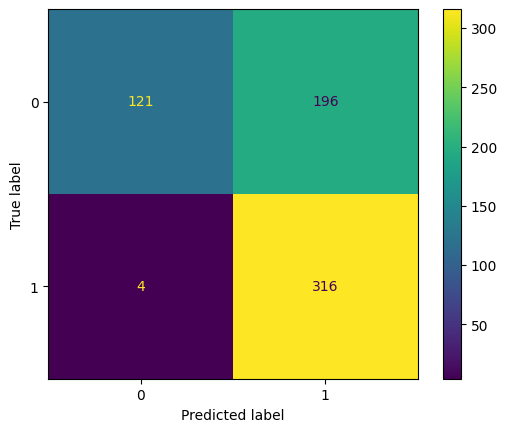

In [11]:
metrics(y_test1, las1_pred)

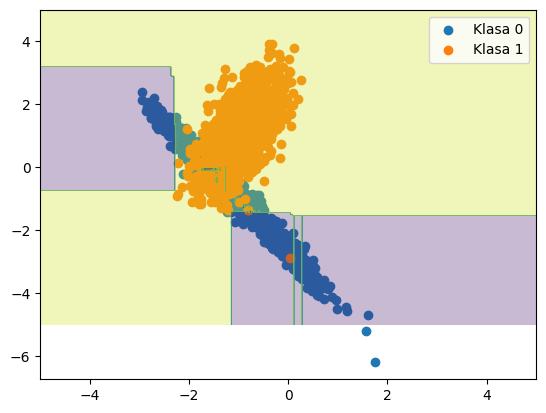

In [12]:
surface(las1, x1, y1)

In [13]:
las1_sk = RandomForestClassifier()
las1_sk.fit(x_train1, y_train1)
las1_sk_pred = las1_sk.predict(x_test1)

accuracy: 0.9010989010989011
sensitivity: 0.890625
specificity: 0.9116719242902208


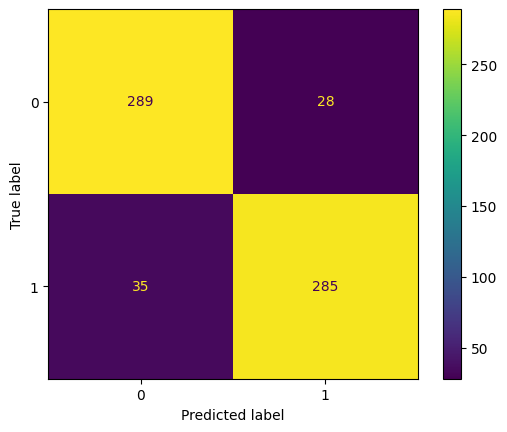

In [14]:
metrics(y_test1, las1_sk_pred)

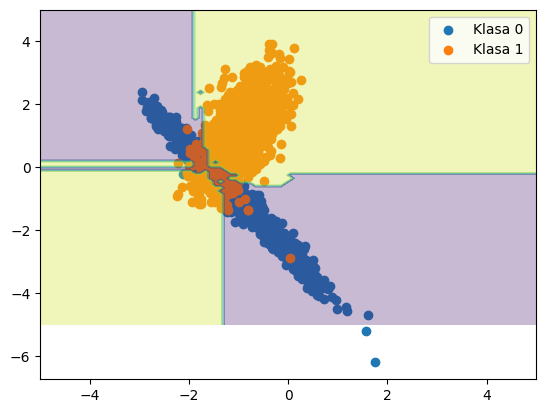

In [15]:
surface_sk(las1_sk, x1, y1)

Implementacja z sklearn radzi sobie lepiej niż własna implementacja.

### Zbiór make_moons

In [16]:
las2 = RandomForestImplementation()
las2.fit(x_train2, y_train2)
las2_pred = las2.predict(x_test2)

accuracy: 0.9105180533751962
sensitivity: 1.0
specificity: 0.8207547169811321


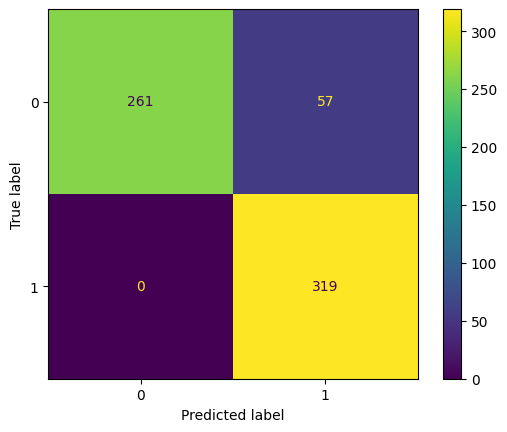

In [17]:
metrics(y_test2, las2_pred)

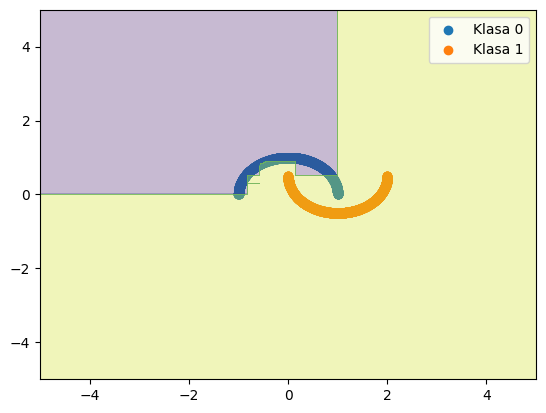

In [18]:
surface(las2, x2, y2)

In [19]:
las2_sk = RandomForestClassifier()
las2_sk.fit(x_train2, y_train2)
las2_sk_pred = las2_sk.predict(x_test2)

accuracy: 1.0
sensitivity: 1.0
specificity: 1.0


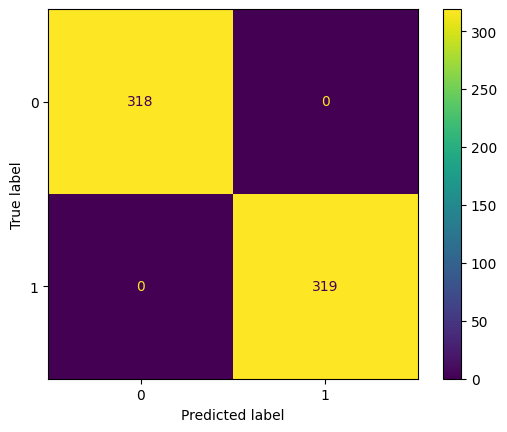

In [20]:
metrics(y_test2, las2_sk_pred)

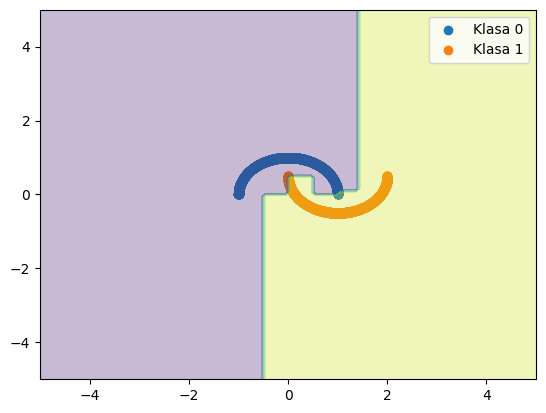

In [21]:
surface_sk(las2_sk, x2, y2)

Implementacja z sklearn poradziła sobie lepiej niż własna implementacja.

### Zbiór wielomodowy

In [22]:
las3 = RandomForestImplementation()
las3.fit(x_train3, y_train3)
las3_pred = las3.predict(x_test3)

accuracy: 0.7880690737833596
sensitivity: 0.9968652037617555
specificity: 0.5786163522012578


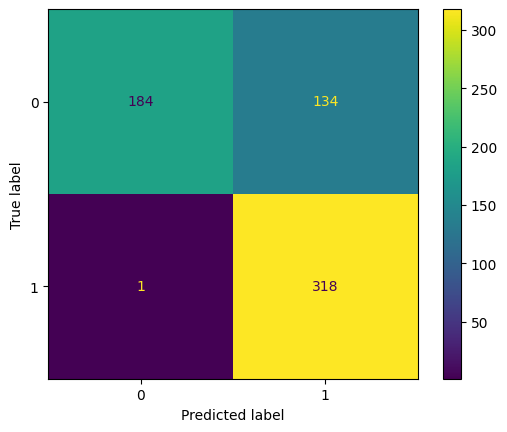

In [23]:
metrics(y_test3, las3_pred)

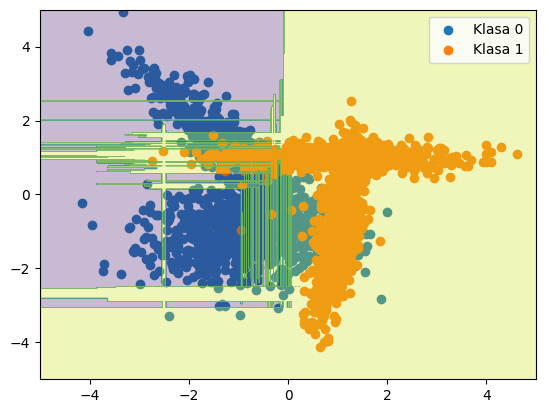

In [24]:
surface(las3, x3, y3)

In [25]:
las3_sk = RandomForestClassifier()
las3_sk.fit(x_train3, y_train3)
las3_sk_pred = las3_sk.predict(x_test3)

accuracy: 0.9324960753532182
sensitivity: 0.9341692789968652
specificity: 0.9308176100628931


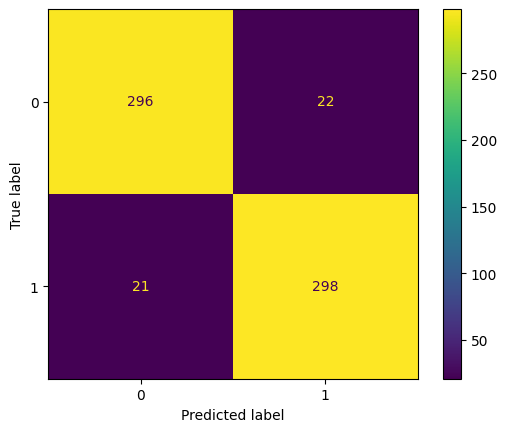

In [26]:
metrics(y_test3, las3_sk_pred)

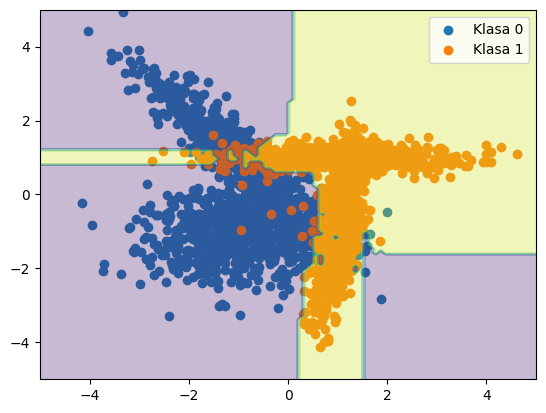

In [27]:
surface_sk(las3_sk, x3, y3)

### Porównanie czasu

In [9]:
start = time.time()
for i in range(5):
    drzewo_czas = RandomForestClassifier(n_estimators=20)
    drzewo_czas.fit(x_train1, y_train1)
    drzewo_czas.predict(x_test1)
end = time.time()
print('Czas dla drzewu losowego z sklearn:', end-start) 

Czas dla drzewu losowego z sklearn: 0.23054718971252441


In [10]:
start = time.time()
for i in range(5):
    drzewo_czas = RandomForestImplementation()
    drzewo_czas.fit(x_train1, y_train1, n_trees=20)
    drzewo_czas.predict(x_test1)
end = time.time()
print('Czas dla drzewu losowego własnej implementacji:', end-start) 

Czas dla drzewu losowego własnej implementacji: 281.6207585334778


## Analiza zbioru NASA JPL Asteroid

In [ ]:
data = pd.read_csv(r"dataset.csv", delimiter=',', low_memory=False)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

In [19]:
data.head()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


Usuwanie zbednych kolumn: id, spkid, full_name, prefix, pdes, name, orbit_id

In [20]:
data.drop(columns=['id', 'spkid', 'full_name', 'prefix', 'pdes', 'name', 'orbit_id', 'equinox', 'class'], inplace=True)

In [21]:
data_droppedna = data.dropna(subset=['neo', 'pha', 'moid', 'moid_ld', 'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'ma', 'H'])

In [22]:
data_droppedna.shape

(932335, 36)

In [23]:
data_droppedna.isnull().sum()

neo                    0
pha                    0
H                      0
diameter          800290
albedo            801095
diameter_sigma    800418
epoch                  0
epoch_mjd              0
epoch_cal              0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     0
ad                     0
n                      0
tp                     0
tp_cal                 0
per                    0
per_y                  0
moid                   0
moid_ld                0
sigma_e                0
sigma_a                0
sigma_q                0
sigma_i                0
sigma_om               0
sigma_w                0
sigma_ma               0
sigma_ad               0
sigma_n                0
sigma_tp               0
sigma_per              0
rms                    0
dtype: int64

W kolumnach diameter, albedo oraz diameter_sigma występuje wiele brakujących wartości, dlatego zostaną usunięte. 

In [24]:
data_droppedna.drop(columns=['diameter', 'albedo', 'diameter_sigma'], inplace=True)

C:\Users\oliwi\AppData\Local\Temp\ipykernel_10984\2149112515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_droppedna.drop(columns=['diameter', 'albedo', 'diameter_sigma'], inplace=True)


Kolumny neo i pha zawierają wartości T/N, zatem zamienimy je na wartości T-1, N-0

In [25]:
data_droppedna['neo'] = data_droppedna['neo'].apply(lambda x: 1 if x=='Y' else 0)

C:\Users\oliwi\AppData\Local\Temp\ipykernel_10984\55149883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_droppedna['neo'] = data_droppedna['neo'].apply(lambda x: 1 if x=='Y' else 0)


In [26]:
data_droppedna['pha'] = data_droppedna['pha'].apply(lambda x: 1 if x=='Y' else 0)

C:\Users\oliwi\AppData\Local\Temp\ipykernel_10984\4185598345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_droppedna['pha'] = data_droppedna['pha'].apply(lambda x: 1 if x=='Y' else 0)


In [27]:
data_droppedna

,neo,pha,H,epoch,epoch_mjd,epoch_cal,e,a,q,i,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
0,0,0,3.400,2458600.5,58600,20190427.0,0.076009,2.769165,2.558684,10.594067,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.43301
1,0,0,4.200,2459000.5,59000,20200531.0,0.229972,2.773841,2.135935,34.832932,...,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,0.35936
2,0,0,5.330,2459000.5,59000,20200531.0,0.256936,2.668285,1.982706,12.991043,...,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,0.33848
3,0,0,3.000,2458600.5,58600,20190427.0,0.088721,2.361418,2.151909,7.141771,...,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,0.39980
4,0,0,6.900,2459000.5,59000,20200531.0,0.190913,2.574037,2.082619,5.367427,...,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,0.52191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958519,0,0,17.135,2437203.5,37203,19600926.0,0.185919,2.280861,1.856807,5.984416,...,7.299800e-01,6.969000e+00,7.433000e+00,4.631100e+01,2.738300e+01,1.041200e+00,1.652100e-01,1.309700e+02,7.264900e+02,0.23839
958520,0,0,18.500,2459000.5,59000,20200531.0,0.282920,2.334910,1.674319,8.082280,...,6.256300e-07,1.563500e-05,5.598600e-05,2.380400e-04,1.298200e-04,2.418900e-08,3.346100e-09,4.690200e-04,1.578500e-05,0.53633
958521,1,1,20.400,2459000.5,59000,20200531.0,0.662446,2.817152,0.950941,4.679278,...,1.687100e-07,1.853300e-05,5.691700e-05,8.969200e-05,5.272600e-05,1.650100e-07,1.101600e-08,2.830600e-04,9.127500e-05,0.51556
958522,0,0,18.071,2441956.5,41956,19731001.0,0.202053,2.373137,1.893638,0.732484,...,5.478400e-01,5.448800e-01,4.391600e+00,1.898800e+01,1.083800e+01,7.171600e-01,1.016700e-01,3.898400e+01,5.035500e+02,0.25641


In [28]:
y_neo = data_droppedna['neo']
y_pha = data_droppedna['pha']

In [21]:
parameters = {'n_estimators':[25, 50], 'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[i for i in range(3, 5)], 'min_samples_split':[4, 5, 6], 'min_samples_leaf':[7, 8]}

In [22]:
x_train, x_test, y_train, y_test = train_test_split(data_droppedna.drop(columns='neo'), y_neo, random_state=254448, stratify=y_neo, test_size=0.95)

In [66]:
forest_nasa = RandomForestClassifier()
gridsearch = GridSearchCV(forest_nasa, parameters, n_jobs=-1, cv=3, verbose=3)
gridsearch.fit(x_train, y_train)

gridsearch.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


RandomForestClassifier(criterion='log_loss', max_depth=4, min_samples_leaf=7,
                       min_samples_split=6, n_estimators=50)

In [67]:
gridsearch.best_params_

{'criterion': 'log_loss',
 'max_depth': 4,
 'min_samples_leaf': 7,
 'min_samples_split': 6,
 'n_estimators': 50}

accuracy: 0.9999966129212539
sensitivity: 0.9999539997239983
specificity: 0.9999976851316003


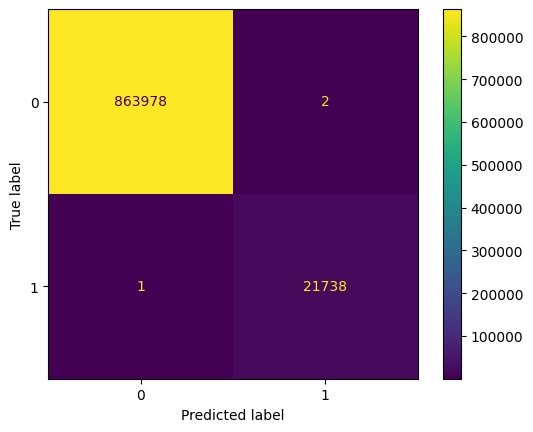

In [68]:
las_nasa_neo = RandomForestClassifier(n_estimators=50, criterion='log_loss', max_depth=4, min_samples_leaf=7, min_samples_split=6)
las_nasa_neo.fit(x_train, y_train)
pred_neo = las_nasa_neo.predict(x_test)
metrics(y_test, pred_neo)

In [90]:
x_train, x_test, y_train, y_test = train_test_split(data_droppedna.drop(columns='pha'), y_pha, random_state=254448, stratify=y_pha, test_size=0.95)

In [73]:
parameters = {'n_estimators':[50, 100], 'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[i for i in range(2, 5)], 'min_samples_split':[6, 7, 8], 'min_samples_leaf':[8,9, 10]}

In [74]:
forest_nasa_pha = RandomForestClassifier()
gridsearch = GridSearchCV(forest_nasa_pha, parameters, n_jobs=-1, cv=3, verbose=3)
gridsearch.fit(x_train, y_train)

gridsearch.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=9,
                       min_samples_split=7, n_estimators=50)

accuracy: 0.9993519389332283
sensitivity: 0.7274579724910851
specificity: 0.99995587017231


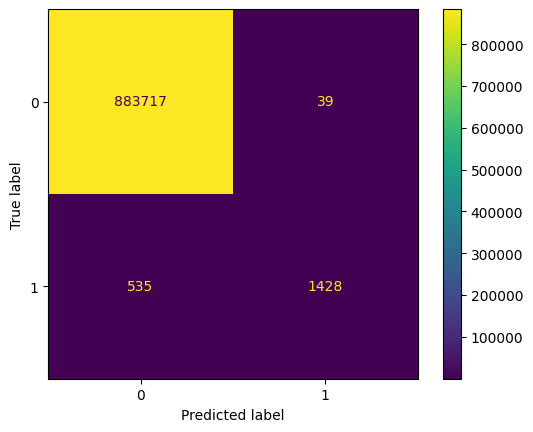

In [75]:
forest_nasa_pha = RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=9, min_samples_split=7, n_estimators=50)
forest_nasa_pha.fit(x_train, y_train)
pred_pha = forest_nasa_pha.predict(x_test)
metrics(y_test, pred_pha)

Wybrane najlepsze hiperparametry różnią się dla PHA i NEO.